In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
import numpy as np

In [4]:
class Simulation:
    def __init__(self, A, initial_state, t_max, sample_rate, num_realizations, S0):
        self.A = A
        self.initial_state = initial_state
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega,rate = self.sc.optimal_omegad(self.A)
        self.optimal_omega = self.optimal_omega*2*np.pi
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 
        self.sample_rate = sample_rate
        self.num_realizations = num_realizations
        self.S0 = S0
        self.t_max = t_max
        self.cplus_state, self.kick_and_sigmax, self.get_projector = self.sc.setup_floquet_system(A,self.optimal_omega)
        self.detuning = np.real(self.sc.H)[2,2] - self.optimal_omega

    def noise_check(self, if_plot=False):
        # Initialize arrays to store results
        tnoise_max = int(self.t_max)             # number of samples
        relative_PSD_strength = self.S0**2
        ifwhite = False               # True for white noise, False for 1/f noise
        
        gn = GenerateNoise(self.sample_rate, tnoise_max, relative_PSD_strength, self.num_realizations, ifwhite)
        trajs = gn.generate_colored_noise()
        self.trajs = trajs
        if if_plot:
            gn.analyze_noise_psd(trajs)
    
    def operators(self):
        sds = self.sc.noise
        sop = self.sc.s
        H_control = self.sc.H_control
        H0 = self.sc.H
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        sds = qt.Qobj(sds)
        sop = qt.Qobj(sop)
        H_control = qt.Qobj(H_control)
        H0 = qt.Qobj(H0)
        return sds, sop, H_control, H0,

    def I_control(self, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Sin-squared ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = amplitude * np.sin((np.pi / 2) * (t[mask1] / ramp_time))**2

            # Flat top
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            result[mask2] = amplitude

            # Sin-squared ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = amplitude * np.sin((np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time))**2

            if result.shape == ():
                return float(result)
            return result

        return pulse

    def Q_control(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        peak = amplitude * np.pi / (2 * ramp_time)

        def pulse_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = peak * np.sin(np.pi * t[mask1] / ramp_time)

            # Derivative of ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = -peak * np.sin(np.pi * (t[mask3] - (T - ramp_time)) / ramp_time)

            result = -result / freq

            if result.shape == ():
                return float(result)
            return result

        return pulse_derivative

    import numpy as np

    def A_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Use boolean masks once
            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up calculations
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)  # More efficient for sqrt(I^2+Q^2)

            # Flat top amplitude is constant
            if np.any(mask2):
                result[mask2] = amplitude

            # Ramp down calculations
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.hypot(I3, Q3)

            if result.shape == ():
                return float(result)
            return result

        return A


    def phi_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up phase
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase
            if np.any(mask2):
                result[mask2] = 0.0

            # Ramp down phase
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.arctan2(Q3, I3)

            if result.shape == ():
                return float(result)
            return result

        return phi



In [1]:
def fit_T2_function(time_points, population_data, omega):
    """
    Fits the model y = exp(-t/T) * cos(omega*t) for the parameter T.
    
    This function now includes bounds to ensure T remains positive.
    """
    
    def model(t, T):
        # Adding a small epsilon to T in the denominator for stability, 
        # although bounds make this less critical.
        return np.exp(-t / (T + 1e-9)) * np.cos(omega * t)

    try:
        # Define bounds for the parameter T: (lower_bound, upper_bound)
        # We set the lower bound to a very small positive number and the upper bound to infinity.
        bounds = (0, np.inf)
        
        # Provide a reasonable initial guess, e.g., the time it takes to decay by half
        initial_guess_T = np.median(time_points)
        
        # Call curve_fit with the bounds
        params, _ = curve_fit(
            model,
            time_points,
            population_data,
            p0=[initial_guess_T],
            bounds=bounds
        )
        fitted_T = params[0]
        
    except (RuntimeError, ValueError) as e:
        # If the fit fails for other reasons, return NaN
        warnings.warn(f"Fit failed with error: {e}")
        fitted_T = np.nan
        
    return fitted_T
def fit_T1_function(time_points, population_data):
    """
    Fits the model y = exp(-t/T) for the parameter T.
    
    This function now includes bounds to ensure T remains positive.
    """
    
    def model(t, T):
        return 1 - np.exp(-t / (T+1e-9))
    
    try:
        bounds = (0, np.inf)
        initial_guess_T = np.median(time_points)
        params, _ = curve_fit(
            model,
            time_points,
            population_data,
            p0=[initial_guess_T],
            bounds=bounds
        )
        fitted_T = params[0]
    except (RuntimeError, ValueError) as e:
        warnings.warn(f"Fit failed with error: {e}")
        fitted_T = np.nan
        
    return fitted_T

import numpy as np
import warnings
from joblib import Parallel, delayed

def calculate_t_phi_uncertainty_via_bootstrap(
    t1_population_matrix,
    t1_time_points,
    fit_t1_func,
    t2_population_matrix,
    t2_time_points,
    fit_t2_func,
    t2_omega,
    num_bootstrap_samples=1000,
    n_jobs=-1
):
    """
    Calculates the mean and standard deviation of the pure dephasing time (T_phi) 
    by bootstrapping the raw T1 and T2 experimental data.

    This method is highly robust as it propagates errors from the raw data level,
    capturing the full uncertainty from the fitting procedures.

    Args:
        t1_population_matrix (np.ndarray): T1 data of shape (num_trajectories, num_t1_times).
        t1_time_points (np.ndarray): 1D array of time points for the T1 experiment.
        fit_t1_func (callable): Function to fit the T1 decay rate.
        t2_population_matrix (np.ndarray): T2 data of shape (num_trajectories, num_t2_times).
        t2_time_points (np.ndarray): 1D array of time points for the T2 experiment.
        fit_t2_func (callable): Function to fit the T2 decay rate.
        t2_omega (float): The angular frequency (detuning) for the T2 fit.
        num_bootstrap_samples (int): The number of bootstrap repetitions.
        n_jobs (int): The number of CPU cores to use for parallel processing.

    Returns:
        tuple: (mean_of_t_phi, std_dev_of_t_phi)
    """
    num_t1_trajectories = t1_population_matrix.shape[0]
    num_t2_trajectories = t2_population_matrix.shape[0]

    def bootstrap_single_iteration(iteration_seed):
        np.random.seed(iteration_seed)

        # --- Bootstrap T1 ---
        t1_indices = np.random.randint(0, num_t1_trajectories, size=num_t1_trajectories)
        t1_resampled_matrix = t1_population_matrix[t1_indices]
        avg_t1_population = np.mean(t1_resampled_matrix, axis=0)
        t1_fit = 1 / fit_t1_func(t1_time_points, avg_t1_population) # Assuming fit func returns rate

        # --- Bootstrap T2 ---
        t2_indices = np.random.randint(0, num_t2_trajectories, size=num_t2_trajectories)
        t2_resampled_matrix = t2_population_matrix[t2_indices]
        avg_t2_population = np.mean(t2_resampled_matrix, axis=0)
        t2_fit = 1 / fit_t2_func(t2_time_points, avg_t2_population, t2_omega) # Assuming fit func returns rate

        # --- Calculate T_phi for this iteration ---
        # Handle the unphysical case where T2 >= 2*T1
        if t2_fit >= 2 * t1_fit:
            return np.nan  # Mark as invalid

        t_phi = 1 / (1 / t2_fit - 1 / (2 * t1_fit))
        return t_phi

    # --- Run all bootstrap iterations in parallel ---
    print(f"Starting {num_bootstrap_samples} bootstrap iterations for T_phi...")
    
    all_t_phi_fits = Parallel(n_jobs=n_jobs)(
        delayed(bootstrap_single_iteration)(i) for i in range(num_bootstrap_samples)
    )

    # --- Final Analysis ---
    successful_fits = [t_phi for t_phi in all_t_phi_fits if not np.isnan(t_phi)]
    
    if len(successful_fits) < num_bootstrap_samples:
        failed_count = num_bootstrap_samples - len(successful_fits)
        warnings.warn(
            f"{failed_count} bootstrap iterations resulted in an unphysical condition (T2 >= 2*T1) and were discarded."
        )

    if not successful_fits:
        warnings.warn("All bootstrap fits failed. Cannot compute statistics.")
        return np.nan, np.nan

    mean_of_t_phi = np.mean(successful_fits)
    std_dev_of_t_phi = np.std(successful_fits, ddof=1)

    return mean_of_t_phi, std_dev_of_t_phi


In [ ]:
def run_full_simulation(A, S0):
    initial_state = []
    t_max = 100000
    num_realizations = 100
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()

    def simulate_trajectory(i, sim, A, t_max, sample_rate, sim_time):
        sds, sop, H_control, H0 = sim.operators()
        time_points = np.linspace(0, sim_time, sim_time)
        floquet_states,sigmax,sigmas = sim.kick_and_sigmax(0)
        get_projector = sim.get_projector
        floquet_ground = floquet_states[:,0]
        floquet_excited = floquet_states[:,1]
        initial_state = qt.Qobj(floquet_excited)
        drive_term = lambda t, args: A * np.cos(sim.optimal_omega * t )
        opts = {'nsteps': t_max, 'atol': 1e-12, 'rtol': 1e-12}
        gamma = 1 / (2e4)
        # Solver options and collapse operators
        opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
        c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
        H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0],[H_control, drive_term]]
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)

        avg_values_single = np.zeros(len(time_points))
        for j, t in enumerate(time_points):
            floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
            projectors = get_projector(floquet_states)
            P00 = projectors[0]
            avg_values_single[j] = qt.expect(P00, result.states[j])
        return avg_values_single

    sim_time = 10000
    num_trajectories = len(sim.trajs)
    t1_time_points = np.linspace(0, sim_time, sim_time)
    # Parallelize the simulation across all trajectories
    avg_values = Parallel(n_jobs=-1)(
        delayed(simulate_trajectory)(i, sim, A, t_max, sample_rate, sim_time) 
        for i in range(num_trajectories)
    )

    # Convert to numpy array with shape (100, sim_time)
    avg_values_T1 = np.array(avg_values)

    def simulate_trajectory(i, sim, A, t_max, sample_rate, sim_time):
        sds, sop, H_control, H0 = sim.operators()
        time_points = np.linspace(0, sim_time, sim_time)
        floquet_states,sigmax,sigmas = sim.kick_and_sigmax(0)
        get_projector = sim.get_projector
        floquet_ground = floquet_states[:,0]
        floquet_excited = floquet_states[:,1]
        initial_state = (qt.Qobj(floquet_ground)+qt.Qobj(floquet_excited)).unit()
        drive_term = lambda t, args: A * np.cos(sim.optimal_omega * t )
        opts = {'nsteps': t_max, 'atol': 1e-12, 'rtol': 1e-12}
        gamma = 1 / (2e4)
        # Solver options and collapse operators
        opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
        c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
        H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0],[H_control, drive_term]]
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)

        avg_values_single = np.zeros(len(time_points))
        for j, t in enumerate(time_points):
            floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
            avg_values_single[j] = qt.expect(qt.Qobj(sigmax), result.states[j])
        return avg_values_single

    sim_time = 50000
    num_trajectories = len(sim.trajs)

    # Parallelize the simulation across all trajectories
    avg_values = Parallel(n_jobs=-1)(
        delayed(simulate_trajectory)(i, sim, A, t_max, sample_rate, sim_time) 
        for i in range(num_trajectories)
    )

    # Convert to numpy array with shape (100, sim_time)
    avg_values_T2 = np.array(avg_values)

    t2_time_points = np.linspace(0, sim_time, sim_time)
    avg, std = calculate_t_phi_uncertainty_via_bootstrap(avg_values_T1,
        t1_time_points,
        fit_T1_function,
        avg_values_T2,
        t2_time_points,
        fit_T2_function,
        sim.sc.fit_omega)
    return avg, std

# Example usage:
A = 5e-3*2*np.pi
S0 = 1e-5
result = run_full_simulation(A, S0)

Starting 1000 bootstrap iterations for T_phi...


(np.float64(9.180084327339666e-07), np.float64(3.144837285512842e-08))

In [41]:
# Fit the averaged data with the exponential decay function
time_points = np.linspace(0, sim_time, sim_time)
avg_population = np.mean(avg_values, axis=0)

# Perform the fit
avg = fit_decay_function(time_points, avg_population, sim.sc.fit_omega)
avg

np.float64(1200513.6961068725)

In [35]:
avg, std = calculate_std_via_block_bootstrap(avg_values, np.linspace(0, sim_time, sim_time), fit_decay_function, sim.sc.fit_omega)

Starting 1000 block bootstrap iterations on all available cores...


In [37]:
avg,std

(np.float64(1199417.946393557), np.float64(32411.054261730347))

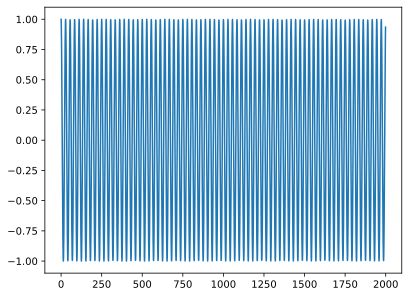

In [7]:
plt.plot(np.mean(avg_values,axis=0))